In [27]:
# 5-1 実験候補の生成
import numpy as np
import polars as pl

num_of_generating_samples = 10000  # 生成するサンプル数
desired_components_sum = 1  # 合計を指定する特徴量がある場合の、合計の値。例えば、この値を 100 にすれば、合計を 100 にできます

generation_settings = pl.read_csv("../test_data/setting_of_generation.csv")
setting_items = generation_settings.get_column("")
generation_settings = generation_settings.drop(setting_items.name)
x_var_names = generation_settings.columns
# 上、下限値を抽出
x_upper = tuple(map(float, generation_settings.row(0)))
x_lower = tuple(map(float, generation_settings.row(1)))
group_setting = tuple(map(int, generation_settings.row(2)))
rounding = tuple(map(int, generation_settings.row(3)))

# 0 から 1 の間の一様乱数でサンプル生成
rng = np.random.default_rng(99)
x_generated = pl.DataFrame(
    {
        col: rng.uniform(
            lower,
            upper,
            num_of_generating_samples,
        )
        for col, upper, lower in zip(x_var_names, x_upper, x_lower)
    }
)

# 合計を desired_sum_of_components にする特徴量がある場合
if sum(group_setting) != 0:
    var_groups = (
        pl.DataFrame({"vars": x_var_names, "group_no": group_setting})
        .group_by("group_no", maintain_order=True)
        .agg(pl.col("vars").implode())
    ).filter(pl.col("group_no") != 0)

    for grouped_vars in var_groups.get_column("vars"):
        x_generated = x_generated.with_columns(
            pl.col(grouped_vars)
            .truediv(pl.sum_horizontal(pl.col(grouped_vars)))
            .mul(desired_components_sum)
        )
    # 全変数が下限以上かつ上限未満である行のみ残す (各列ごとに [x_lower, x_upper) を満たすこと)
    mask = x_generated.select(
        [
            (pl.col(col) >= lower) & (pl.col(col) < upper)
            for col, lower, upper in zip(x_var_names, x_lower, x_upper)
        ]
    ).min_horizontal()
    x_generated = x_generated.filter(mask)

# 数値の丸め込みをする場合
if "rounding" in setting_items:
    x_generated = x_generated.with_columns(
        [
            pl.col(col)
            .mul(10**round_digit)
            .round(0, "half_away_from_zero")
            .truediv(10**round_digit)
            for col, round_digit in zip(x_var_names, rounding)
        ]
    )

# temperatureとtimeをint型に変換
x_generated = x_generated.with_columns(
    [
        pl.col("temperature").cast(pl.Int64),
        pl.col("time").cast(pl.Int64),
    ]
)

# 保存
x_generated.write_csv("../output/generated_samples.csv")


In [37]:
# 5.2 実験候補の選択
import numpy as np
import polars as pl

number_of_selecting_samples = 30  # 選択するサンプル数
number_of_random_searches = (
    1000  # ランダムにサンプルを選択して D 最適基準を計算する繰り返し回数
)

x_generated = pl.read_csv("../output/generated_samples.csv")
x_generated_wt_row_index = x_generated.with_row_index()
autoscaled_x_generated = x_generated.select(
    (pl.all() - pl.all().mean()) / pl.all().std()
)
row_idx_name = "index"
autoscaled_x_generated_wt_row_index = autoscaled_x_generated.with_row_index(
    row_idx_name
)


# D 最適基準に基づくサンプル選択
rng = np.random.default_rng(11)  # 乱数を生成するためのシードを固定
pl.set_random_seed(11)
for random_search_number in range(number_of_random_searches):
    # 1. ランダムに候補を選択
    new_selected_samples_wt_row_index = autoscaled_x_generated_wt_row_index.sample(
        n=number_of_selecting_samples, with_replacement=False, shuffle=False
    )
    new_selected_row_index = new_selected_samples_wt_row_index[row_idx_name]
    new_selected_samples_np = new_selected_samples_wt_row_index.drop(
        row_idx_name
    ).to_numpy()
    # 2. D 最適基準を計算
    xt_x = np.dot(new_selected_samples_np.T, new_selected_samples_np)
    d_optimal_value = np.linalg.det(xt_x)

    # 3. D 最適基準が前回までの最大値を上回ったら、選択された候補を更新
    if random_search_number == 0:
        best_d_optimal_value = d_optimal_value.copy()
        selected_row_index = new_selected_row_index.implode()
        selected_samples = x_generated_wt_row_index.filter(
            pl.col(row_idx_name).is_in(selected_row_index)
        ).drop(row_idx_name)
    else:
        if best_d_optimal_value < d_optimal_value:
            best_d_optimal_value = d_optimal_value.copy()
            selected_row_index = new_selected_row_index.implode()
            selected_samples = x_generated_wt_row_index.filter(
                pl.col(row_idx_name).is_in(selected_row_index)
            ).drop(row_idx_name)

# 選択されなかったサンプル
remaining_samples = x_generated_wt_row_index.filter(
    ~pl.col(row_idx_name).is_in(selected_row_index)
).drop(row_idx_name)

# 保存
selected_samples.clone().with_row_index(offset=1).write_csv(
    "../output/selected_samples.csv"
)  # 選択されたサンプルを csv ファイルに保存。同じ名前のファイルがあるときは上書きされるため注意
remaining_samples.clone().with_row_index(offset=1).write_csv(
    "../output/remaining_samples.csv"
)  # 選択されなかったサンプルを csv ファイルに保存。同じ名前のファイルがあるときは上書きされるため注意

print(selected_samples.corr())  # 相関行列の確認

shape: (5, 5)
┌────────────────┬────────────────┬────────────────┬─────────────┬───────────┐
│ raw material 1 ┆ raw material 2 ┆ raw material 3 ┆ temperature ┆ time      │
│ ---            ┆ ---            ┆ ---            ┆ ---         ┆ ---       │
│ f64            ┆ f64            ┆ f64            ┆ f64         ┆ f64       │
╞════════════════╪════════════════╪════════════════╪═════════════╪═══════════╡
│ 1.0            ┆ -0.479386      ┆ -0.669555      ┆ -0.016241   ┆ -0.265211 │
│ -0.479386      ┆ 1.0            ┆ -0.330387      ┆ 0.032651    ┆ 0.020392  │
│ -0.669555      ┆ -0.330387      ┆ 1.0            ┆ -0.009974   ┆ 0.264769  │
│ -0.016241      ┆ 0.032651       ┆ -0.009974      ┆ 1.0         ┆ 0.189578  │
│ -0.265211      ┆ 0.020392       ┆ 0.264769       ┆ 0.189578    ┆ 1.0       │
└────────────────┴────────────────┴────────────────┴─────────────┴───────────┘


c:\Users\sato1\Documents\myscript\python_doe_kspub\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


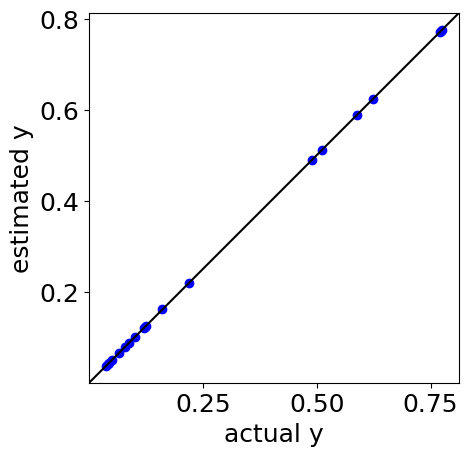

r^2 for training data : 0.9999999931263742
RMSE for training data : 2.2790784973808692e-05
MAE for training data : 1.7018909766406895e-05


c:\Users\sato1\Documents\myscript\python_doe_kspub\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\sato1\Documents\myscript\python_doe_kspub\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\sato1\Documents\myscript\python_doe_kspub\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.


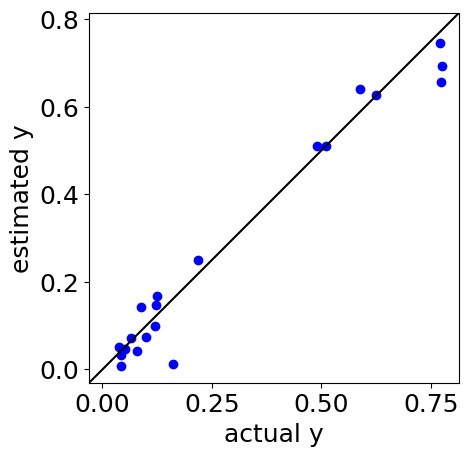

r^2 in cross-validation : 0.9626474714375198
RMSE in cross-validation : 0.05312835207520736
MAE in cross-validation : 0.03772294067072186

トレーニングデータにおけるサポートベクター数 : 10
トレーニングデータにおけるサポートベクターの割合 : 0.5

トレーニングデータにおける外れサンプル数 : 4
トレーニングデータにおける外れサンプルの割合 : 0.2

テストデータにおける外れサンプル数 : 4381
テストデータにおける外れサンプルの割合 : 0.4505810963694333


In [38]:
# 5.3 次の実験候補の選択

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    RBF,
    ConstantKernel,
    DotProduct,
    Matern,
    WhiteKernel,
)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, cross_val_predict
from sklearn.neighbors import NearestNeighbors
from sklearn.svm import SVR, OneClassSVM

regression_method = "gpr_one_kernel"  # 回帰分析手法 'ols_linear', 'ols_nonlinear', 'svr_linear', 'svr_gaussian', 'gpr_one_kernel', 'gpr_kernels'
ad_method = "ocsvm"  # AD設定手法 'knn', 'ocsvm', 'ocsvm_gamma_optimization'

fold_number = 10  # クロスバリデーションの fold 数
rate_of_training_samples_inside_ad = (
    0.96  # AD 内となるトレーニングデータの割合。AD　のしきい値を決めるときに使用
)

linear_svr_cs = 2.0 ** pl.arange(-10, 5, eager=True)  # 線形SVR の C の候補
linear_svr_epsilons = 2.0 ** pl.arange(-10, 0, eager=True)  # 線形SVRの ε の候補
nonlinear_svr_cs = 2.0 ** pl.arange(-5, 10, eager=True)  # SVR の C の候補
nonlinear_svr_epsilons = 2.0 ** pl.arange(-10, 0, eager=True)  # SVR の ε の候補
# SVR のガウシアンカーネルの γ の候補
nonlinear_svr_gammas = 2.0 ** pl.arange(-20, 10, eager=True)
kernel_number = 2  # 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10
k_in_knn = 5  # k-NN における k
ocsvm_nu = 0.04  # OCSVM における ν。トレーニングデータにおけるサンプル数に対する、サポートベクターの数の下限の割合
ocsvm_gamma = 0.1  # OCSVM における γ
ocsvm_gammas = 2.0 ** pl.arange(-20, 11, eager=True)  # γ の候補

dataset = pl.read_csv("../test_data/resin.csv")
dataset = dataset.drop(dataset.columns[0])
x_prediction = pl.read_csv("../output/remaining_samples.csv")

# データ分割
y = dataset.get_column("property")  # 目的変数
x = dataset.drop(y.name)  # 説明変数


# 説明変数の二乗項や交差項を追加
def add_sqrt_and_interaction_terms(df: pl.DataFrame) -> pl.DataFrame:
    from itertools import combinations

    return df.with_columns(  # 二乗項の追加
        [(pl.col(col) ** 2).alias(f"{col}^2") for col in df.columns]
    ).with_columns(  # 交差項の追加
        [
            (pl.col(col1) * pl.col(col2)).alias(f"{col1}*{col2}")
            for col1, col2 in combinations(df.columns, 2)
        ]
    )


if regression_method == "ols_nonlinear":
    print("\n二乗項と交差項の追加")
    x = add_sqrt_and_interaction_terms(x)
    x_prediction = add_sqrt_and_interaction_terms(x_prediction)

# 標準偏差が 0 の特徴量の削除
std_stats = x.select(pl.all().std())
valid_cols = [c for c in x.columns if std_stats[c][0] != 0]
x = x.select(valid_cols)
x_prediction = x_prediction.select(valid_cols)

# カーネル 11 種類
kernels = [
    ConstantKernel() * DotProduct() + WhiteKernel(),
    ConstantKernel() * RBF() + WhiteKernel(),
    ConstantKernel() * RBF() + WhiteKernel() + ConstantKernel() * DotProduct(),
    ConstantKernel() * RBF(np.ones(x.shape[1])) + WhiteKernel(),
    ConstantKernel() * RBF(np.ones(x.shape[1]))
    + WhiteKernel()
    + ConstantKernel() * DotProduct(),
    ConstantKernel() * Matern(nu=1.5) + WhiteKernel(),
    ConstantKernel() * Matern(nu=1.5) + WhiteKernel() + ConstantKernel() * DotProduct(),
    ConstantKernel() * Matern(nu=0.5) + WhiteKernel(),
    ConstantKernel() * Matern(nu=0.5) + WhiteKernel() + ConstantKernel() * DotProduct(),
    ConstantKernel() * Matern(nu=2.5) + WhiteKernel(),
    ConstantKernel() * Matern(nu=2.5) + WhiteKernel() + ConstantKernel() * DotProduct(),
]

# オートスケーリング
autoscaled_y = (y - y.mean()) / y.std()
autoscaled_x = x.select((pl.all() - pl.all().mean()) / pl.all().std())
x_prediction = x_prediction.select(x.columns)
autoscaled_x_prediction = (
    x_prediction - x.mean().select(pl.all().repeat_by(x_prediction.height).explode())
) / x.std().select(pl.all().repeat_by(x_prediction.height).explode())

# sklearn 用に numpy 配列化
x_train = autoscaled_x.to_numpy()
y_train = autoscaled_y.to_numpy()
x_pred = autoscaled_x_prediction.to_numpy()

# モデル構築
if regression_method == "ols_linear" or regression_method == "ols_nonlinear":
    model = LinearRegression()
elif regression_method == "svr_linear":
    # クロスバリデーションによる C, ε の最適化
    cross_validation = KFold(
        n_splits=fold_number, random_state=9, shuffle=True
    )  # クロスバリデーションの分割の設定
    gs_cv = GridSearchCV(
        SVR(kernel="linear"),
        {"C": linear_svr_cs.to_numpy(), "epsilon": linear_svr_epsilons.to_numpy()},
        cv=cross_validation,
    )  # グリッドサーチの設定
    gs_cv.fit(x_train, y_train)  # グリッドサーチ + クロスバリデーション実施
    optimal_linear_svr_c = gs_cv.best_params_["C"]  # 最適な C
    optimal_linear_svr_epsilon = gs_cv.best_params_["epsilon"]  # 最適な ε
    print(
        "最適化された C : {0} (log(C)={1})".format(
            optimal_linear_svr_c, np.log2(optimal_linear_svr_c)
        )
    )
    print(
        "最適化された ε : {0} (log(ε)={1})".format(
            optimal_linear_svr_epsilon, np.log2(optimal_linear_svr_epsilon)
        )
    )
    model = SVR(
        kernel="linear", C=optimal_linear_svr_c, epsilon=optimal_linear_svr_epsilon
    )  # SVRモデルの宣言
elif regression_method == "svr_gaussian":
    # C, ε, γの最適化
    # グラム行列の分散が最大となるγを探索
    autoscaled_x_train_wt_var_list = autoscaled_x.select(
        pl.concat_list(pl.all()).alias("sample")
    )
    sample_distances = (
        # すべてのサンプルを組み合わせる
        autoscaled_x_train_wt_var_list.join(
            autoscaled_x_train_wt_var_list, how="cross", suffix="_right"
        )
        .select(
            # 全サンプル間の全データのユークリッド距離の二乗を計算
            (pl.col("sample") - pl.col("sample_right"))
            .list.eval(pl.element().pow(2))
            .list.sum()
            .implode()  # グラム行列の計算を簡単にするために、全距離をリスト化
            .alias("distance"),
        )
        .to_series(0)
    )

    gram_matrix = (-nonlinear_svr_gammas * sample_distances).list.eval(
        pl.element().exp()
    )
    optimal_nonlinear_gamma: float = nonlinear_svr_gammas.item(
        gram_matrix.list.var().arg_max()
    )

    # CV による最適化
    # クロスバリデーションの分割の設定
    cross_validation = KFold(n_splits=fold_number, random_state=9, shuffle=True)

    def calc_r2(
        C: float, epsilon: float, gamma: float, x, y, y_true: pl.Series
    ) -> float:
        model = SVR(kernel="rbf", C=C, epsilon=epsilon, gamma=gamma)
        autoscaled_estimated_y_in_cv = cross_val_predict(
            model, x, y, cv=cross_validation
        )
        return r2_score(
            y_true, autoscaled_estimated_y_in_cv * y_true.std() + y_true.mean()
        )

    # CVによる ε の最適化
    r2_cvs = nonlinear_svr_epsilons.map_elements(
        lambda epsilon: calc_r2(
            3,
            epsilon,
            optimal_nonlinear_gamma,
            x_train,
            y_train,
            y_train,
        )
    )
    optimal_nonlinear_epsilon: float = nonlinear_svr_epsilons.item(r2_cvs.arg_max())

    # CV による C の最適化
    r2_cvs = nonlinear_svr_cs.map_elements(
        lambda c: calc_r2(
            c,
            optimal_nonlinear_epsilon,
            optimal_nonlinear_gamma,
            x_train,
            y_train,
            y_train,
        )
    )
    optimal_nonlinear_c: float = nonlinear_svr_cs.item(r2_cvs.arg_max())

    # CV による γ の最適化
    r2_cvs = nonlinear_svr_gammas.map_elements(
        lambda gamma: calc_r2(
            optimal_nonlinear_c,
            optimal_nonlinear_epsilon,
            gamma,
            x_train,
            y_train,
            y_train,
        )
    )
    optimal_nonlinear_gamma: float = nonlinear_svr_gammas.item(r2_cvs.arg_max())

    # 結果の確認
    print(
        "最適化された C : {0} (log(C)={1})".format(
            optimal_nonlinear_c, np.log2(optimal_nonlinear_c)
        )
    )
    print(
        "最適化された ε : {0} (log(ε)={1})".format(
            optimal_nonlinear_epsilon, np.log2(optimal_nonlinear_epsilon)
        )
    )
    print(
        "最適化された γ : {0} (log(γ)={1})".format(
            optimal_nonlinear_gamma, np.log2(optimal_nonlinear_gamma)
        )
    )
    # モデル構築
    model = SVR(
        kernel="rbf",
        C=optimal_nonlinear_c,
        epsilon=optimal_nonlinear_epsilon,
        gamma=optimal_nonlinear_gamma,
    )  # SVR モデルの宣言
elif regression_method == "gpr_one_kernel":
    selected_kernel = kernels[kernel_number]
    model = GaussianProcessRegressor(alpha=0, kernel=selected_kernel)
elif regression_method == "gpr_kernels":
    # クロスバリデーションによるカーネル関数の最適化
    cross_validation = KFold(
        n_splits=fold_number, random_state=9, shuffle=True
    )  # クロスバリデーションの分割の設定
    r2cvs = []  # 空の list。主成分の数ごとに、クロスバリデーション後の r2 を入れていきます
    for index, kernel in enumerate(kernels):
        print(index + 1, "/", len(kernels))
        model = GaussianProcessRegressor(alpha=0, kernel=kernel)
        estimated_y_in_cv = np.ndarray.flatten(
            cross_val_predict(model, x_train, y_train, cv=cross_validation)
        )
        # r2_score on autoscaled values is fine for selection
        r2cvs.append(r2_score(y_train, estimated_y_in_cv))
    optimal_kernel_number = np.where(r2cvs == np.max(r2cvs))[0][
        0
    ]  # クロスバリデーション後の r2 が最も大きいカーネル関数の番号
    optimal_kernel = kernels[
        optimal_kernel_number
    ]  # クロスバリデーション後の r2 が最も大きいカーネル関数
    print("クロスバリデーションで選択されたカーネル関数の番号 :", optimal_kernel_number)
    print("クロスバリデーションで選択されたカーネル関数 :", optimal_kernel)

    # モデル構築
    model = GaussianProcessRegressor(alpha=0, kernel=optimal_kernel)  # GPR モデルの宣言

model.fit(x_train, y_train)  # モデル構築

# 標準回帰係数
if regression_method in ["ols_linear", "ols_nonlinear", "svr_linear"]:
    if regression_method == "svr_linear":
        coefs = model.coef_.T
    else:
        coefs = model.coef_

    standard_regression_coefficients = pl.DataFrame(
        {"standard_regression_coefficients": coefs.flatten()}
    ).with_columns(pl.Series("variable", x.columns))

    standard_regression_coefficients.write_csv(
        f"../output/standard_regression_coefficients_{regression_method}.csv"
    )

# トレーニングデータの推定
autoscaled_estimated_y = model.predict(x_train)
estimated_y = autoscaled_estimated_y * y.std() + y.mean()
estimated_y_df = pl.DataFrame({"estimated_y": estimated_y})

# トレーニングデータの実測値 vs. 推定値のプロット
plt.rcParams["font.size"] = 18
plt.scatter(y, estimated_y, c="blue")
y_max = max(y.max(), estimated_y.max())
y_min = min(y.min(), estimated_y.min())
plt.plot(
    [y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)],
    [y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)],
    "k-",
)
plt.ylim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))
plt.xlim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))
plt.xlabel("actual y")
plt.ylabel("estimated y")
plt.gca().set_aspect("equal", adjustable="box")
plt.show()

# トレーニングデータのr2, RMSE, MAE
print("r^2 for training data :", r2_score(y, estimated_y))
print("RMSE for training data :", root_mean_squared_error(y, estimated_y))
print("MAE for training data :", mean_absolute_error(y, estimated_y))

# トレーニングデータの結果の保存
results_train = pl.DataFrame(
    {
        "actual_y": y,
        "estimated_y": estimated_y,
        "error_of_y(actual_y-estimated_y)": y - estimated_y,
    }
)
results_train.write_csv(f"../output/estimated_y_in_detail_{regression_method}.csv")

# クロスバリデーションによる y の値の推定
cross_validation = KFold(n_splits=fold_number, random_state=9, shuffle=True)
autoscaled_estimated_y_in_cv = cross_val_predict(
    model, x_train, y_train, cv=cross_validation
)
estimated_y_in_cv = autoscaled_estimated_y_in_cv * y.std() + y.mean()

# クロスバリデーションにおける実測値 vs. 推定値のプロット
plt.rcParams["font.size"] = 18
plt.scatter(y, estimated_y_in_cv, c="blue")
y_max = max(y.max(), estimated_y_in_cv.max())
y_min = min(y.min(), estimated_y_in_cv.min())
plt.plot(
    [y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)],
    [y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)],
    "k-",
)
plt.ylim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))
plt.xlim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))
plt.xlabel("actual y")
plt.ylabel("estimated y")
plt.gca().set_aspect("equal", adjustable="box")
plt.show()

# クロスバリデーションにおけるr2, RMSE, MAE
print("r^2 in cross-validation :", r2_score(y, estimated_y_in_cv))
print(
    "RMSE in cross-validation :",
    root_mean_squared_error(y, estimated_y_in_cv),
)
print("MAE in cross-validation :", mean_absolute_error(y, estimated_y_in_cv))

# クロスバリデーションの結果の保存
results_in_cv = pl.DataFrame(
    {
        "actual_y": y,
        "estimated_y": estimated_y_in_cv,
        "error_of_y(actual_y-estimated_y)": y - estimated_y_in_cv,
    }
)
results_in_cv.write_csv(
    f"../output/estimated_y_in_cv_in_detail_{regression_method}.csv"
)

# 予測
if regression_method in ["gpr_one_kernel", "gpr_kernels"]:
    estimated_y_prediction, estimated_y_prediction_std = model.predict(
        x_pred, return_std=True
    )
    estimated_y_prediction_std = estimated_y_prediction_std * y.std()
    pl.DataFrame({"std_of_estimated_y": estimated_y_prediction_std}).write_csv(
        f"../output/estimated_y_prediction_{regression_method}_std.csv"
    )
else:
    estimated_y_prediction = model.predict(x_pred)

estimated_y_prediction = estimated_y_prediction * y.std() + y.mean()
estimated_y_prediction_df = pl.DataFrame({"estimated_y": estimated_y_prediction})
estimated_y_prediction_df.write_csv(
    f"../output/estimated_y_prediction_{regression_method}.csv"
)

# 非線形変換を戻す
# Polarsでは元のx, x_predictionを保持しておけばよいが、ここでは再読み込みやコピーの代わりに
# 必要な列だけ選択しなおすなどの処理が必要だが、元のコードでは x_tmp を使っていた。
# 今回のRefactoringでは x_tmp を使わず、x 自体を変換してしまったので、
# もし元の x が必要なら、変換前にコピーしておくべきだったが、
# 予測後の処理で x を使うのは AD の部分。
# AD は autoscaled_x を使うので、非線形変換後の x でよいのか？
# 元のコードでは:
# if regression_method == "ols_nonlinear":
#    x = x_tmp.copy() ...
# と戻している。つまり AD は元の特徴量空間で行う（非線形項を含まない）。
# したがって、AD の前に x を元に戻す必要がある。
# しかし、ここでは x を上書きしてしまった。
# 修正案: 非線形変換のブロックで x_original を保存しておく。
# または、AD のブロックで x を再読み込みする。
# ここでは AD ブロックの前に x を再構築するロジックを入れる。

if regression_method == "ols_nonlinear":
    # 元のデータを再取得 (簡易的)
    # dataset はまだある
    x = dataset.drop(y.name)
    x_prediction = pl.read_csv("../output/remaining_samples.csv")
    # x_prediction = x_prediction.drop(x_prediction.columns[0])

    # std=0 削除
    std_stats = x.select(pl.all().std())
    valid_cols = [c for c in x.columns if std_stats[c][0] != 0]
    x = x.select(valid_cols)
    x_prediction = x_prediction.select(valid_cols)

    # オートスケーリング
    autoscaled_x = x.select((pl.all() - pl.all().mean()) / pl.all().std())
    autoscaled_x_prediction = (
        x_prediction
        - x.mean().select(pl.all().repeat_by(x_prediction.height).explode())
    ) / x.std().select(pl.all().repeat_by(x_prediction.height).explode())

    x_train = autoscaled_x.to_numpy()
    x_pred = autoscaled_x_prediction.to_numpy()

# AD
if ad_method == "knn":
    ad_model = NearestNeighbors(n_neighbors=k_in_knn, metric="euclidean")
    ad_model.fit(x_train)

    knn_distance_train, _ = ad_model.kneighbors(x_train, n_neighbors=k_in_knn + 1)
    mean_of_knn_distance_train = knn_distance_train[:, 1:].mean(axis=1)

    pl.DataFrame({"mean_of_knn_distance": mean_of_knn_distance_train}).write_csv(
        "../output/mean_of_knn_distance_train.csv"
    )

    sorted_dist = np.sort(mean_of_knn_distance_train)
    ad_threshold = sorted_dist[
        round(len(x_train) * rate_of_training_samples_inside_ad) - 1
    ]
    inside_ad_flag_train = mean_of_knn_distance_train <= ad_threshold

    knn_distance_prediction, _ = ad_model.kneighbors(x_pred)
    mean_of_knn_distance_prediction = knn_distance_prediction.mean(axis=1)
    inside_ad_flag_prediction = mean_of_knn_distance_prediction <= ad_threshold

    ad_index_prediction = mean_of_knn_distance_prediction

elif ad_method == "ocsvm":
    if ad_method == "ocsvm_gamma_optimization":
        # グラム行列の分散が最大となるγを探索
        autoscaled_x_train_wt_var_list = autoscaled_x.select(
            pl.concat_list(pl.all()).alias("sample")
        )
        sample_distances = (
            # すべてのサンプルを組み合わせる
            autoscaled_x_train_wt_var_list.join(
                autoscaled_x_train_wt_var_list, how="cross", suffix="_right"
            )
            .select(
                # 全サンプル間の全データのユークリッド距離の二乗を計算
                (pl.col("sample") - pl.col("sample_right"))
                .list.eval(pl.element().pow(2))
                .list.sum()
                .implode()  # グラム行列の計算を簡単にするために、全距離をリスト化
                .alias("distance"),
            )
            .to_series(0)
        )

        gram_matrix = (-ocsvm_gammas * sample_distances).list.eval(pl.element().exp())
        optimal_gamma: float = ocsvm_gammas.item(gram_matrix.list.var().arg_max())
        print("最適化された gamma :", optimal_gamma)
    else:
        optimal_gamma = ocsvm_gamma

    ad_model = OneClassSVM(kernel="rbf", gamma=optimal_gamma, nu=ocsvm_nu)
    ad_model.fit(x_train)

    data_density_train = ad_model.decision_function(x_train)
    number_of_support_vectors = len(ad_model.support_)
    number_of_outliers_in_training_data = sum(data_density_train < 0)
    print("\nトレーニングデータにおけるサポートベクター数 :", number_of_support_vectors)
    print(
        "トレーニングデータにおけるサポートベクターの割合 :",
        number_of_support_vectors / len(x_train),
    )
    print(
        "\nトレーニングデータにおける外れサンプル数 :",
        number_of_outliers_in_training_data,
    )
    print(
        "トレーニングデータにおける外れサンプルの割合 :",
        number_of_outliers_in_training_data / len(x_train),
    )

    pl.DataFrame({"ocsvm_data_density": data_density_train}).write_csv(
        "../output/ocsvm_data_density_train.csv"
    )
    inside_ad_flag_train = data_density_train >= 0

    ad_index_prediction = ad_model.decision_function(x_pred)
    number_of_outliers_in_prediction_data = sum(ad_index_prediction < 0)
    print(
        "\nテストデータにおける外れサンプル数 :", number_of_outliers_in_prediction_data
    )
    print(
        "テストデータにおける外れサンプルの割合 :",
        number_of_outliers_in_prediction_data / len(x_pred),
    )

    pl.DataFrame({"ocsvm_data_density": ad_index_prediction}).write_csv(
        "../output/ocsvm_ad_index_prediction.csv"
    )
    inside_ad_flag_prediction = ad_index_prediction >= 0

# AD外の予測値をマスク
estimated_y_prediction[~inside_ad_flag_prediction] = -1e10

# 保存
pl.DataFrame({"inside_ad_flag": inside_ad_flag_train}).write_csv(
    f"../output/inside_ad_flag_train_{ad_method}.csv"
)
pl.DataFrame({"inside_ad_flag": inside_ad_flag_prediction}).write_csv(
    f"../output/inside_ad_flag_prediction_{ad_method}.csv"
)
pl.DataFrame({"ad_index_prediction": ad_index_prediction}).write_csv(
    f"../output/ad_index_prediction_{ad_method}.csv"
)
pl.DataFrame({"estimated_y": estimated_y_prediction}).write_csv(
    f"../output/estimated_y_prediction_considering_ad_{regression_method}_{ad_method}.csv"
)

# 次のサンプル
max_idx = np.argmax(estimated_y_prediction)
next_sample = x_prediction.slice(int(max_idx), 1)
next_sample.write_csv(f"../output/next_sample_{regression_method}_{ad_method}.csv")


c:\Users\sato1\Documents\myscript\python_doe_kspub\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


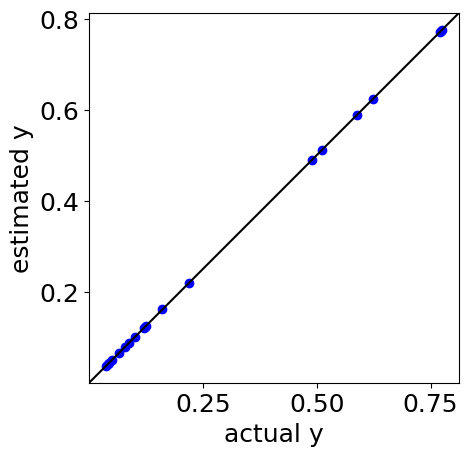

r^2 for training data : 0.9999999931263742
RMSE for training data : 2.2790784973808692e-05
MAE for training data : 1.7018909766406895e-05


c:\Users\sato1\Documents\myscript\python_doe_kspub\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\sato1\Documents\myscript\python_doe_kspub\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\sato1\Documents\myscript\python_doe_kspub\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.


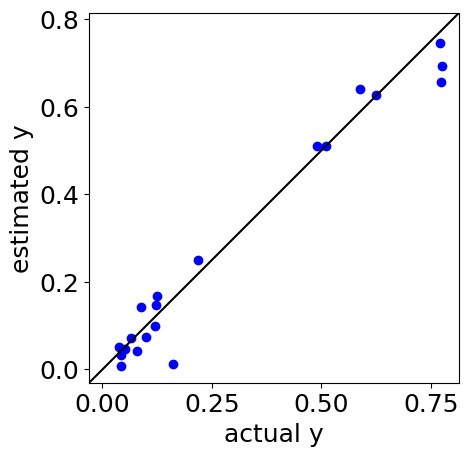

r^2 in cross-validation : 0.9626474714375198
RMSE in cross-validation : 0.05312835207520736
MAE in cross-validation : 0.03772294067072186
sample number : 1 / 5


c:\Users\sato1\Documents\myscript\python_doe_kspub\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\sato1\Documents\myscript\python_doe_kspub\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


sample number : 2 / 5
sample number : 3 / 5
sample number : 4 / 5
sample number : 5 / 5


c:\Users\sato1\Documents\myscript\python_doe_kspub\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\sato1\Documents\myscript\python_doe_kspub\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


In [39]:
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    RBF,
    ConstantKernel,
    DotProduct,
    Matern,
    WhiteKernel,
)
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.model_selection import KFold, cross_val_predict

# 5.4 ベイズ最適化による実験候補の選択

number_of_selecting_samples = 5  # 選択するサンプル数
regression_method = "gpr_one_kernel"  # gpr_one_kernel', 'gpr_kernels'
acquisition_function = "PTR"  # 'PTR', 'PI', 'EI', 'MI'

fold_number = 10  # クロスバリデーションの fold 数
kernel_number = 2  # 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10
target_range = [0, 1]  # PTR
relaxation = 0.01  # EI, PI
delta = 10**-6  # MI

dataset = pl.read_csv("../test_data/resin.csv")
dataset = dataset.drop(dataset.columns[0])
x_prediction = pl.read_csv("../output/remaining_samples.csv")

# データ分割
y = dataset.get_column("property")  # 目的変数
x = dataset.drop(y.name)  # 説明変数

# 標準偏差が 0 の特徴量の削除
std_stats = x.select(pl.all().std())
valid_cols = [c for c in x.columns if std_stats[c][0] != 0]
x = x.select(valid_cols)
x_prediction = x_prediction.select(valid_cols)

cumulative_variance = np.zeros(
    x_prediction.height
)  # MI で必要な "ばらつき" を 0 で初期化

# カーネル 11 種類
kernels = [
    ConstantKernel() * DotProduct() + WhiteKernel(),
    ConstantKernel() * RBF() + WhiteKernel(),
    ConstantKernel() * RBF() + WhiteKernel() + ConstantKernel() * DotProduct(),
    ConstantKernel() * RBF(np.ones(x.shape[1])) + WhiteKernel(),
    ConstantKernel() * RBF(np.ones(x.shape[1]))
    + WhiteKernel()
    + ConstantKernel() * DotProduct(),
    ConstantKernel() * Matern(nu=1.5) + WhiteKernel(),
    ConstantKernel() * Matern(nu=1.5) + WhiteKernel() + ConstantKernel() * DotProduct(),
    ConstantKernel() * Matern(nu=0.5) + WhiteKernel(),
    ConstantKernel() * Matern(nu=0.5) + WhiteKernel() + ConstantKernel() * DotProduct(),
    ConstantKernel() * Matern(nu=2.5) + WhiteKernel(),
    ConstantKernel() * Matern(nu=2.5) + WhiteKernel() + ConstantKernel() * DotProduct(),
]

# Bayesian optimization
next_samples = pl.DataFrame(
    schema=x_prediction.schema
)  # 次のサンプルを入れる変数を準備
for sample_number in range(number_of_selecting_samples):
    # オートスケーリング
    autoscaled_y = (y - y.mean()) / y.std()
    autoscaled_x = x.select((pl.all() - pl.all().mean()) / pl.all().std())
    autoscaled_x_prediction = (
        x_prediction
        - x.mean().select(pl.all().repeat_by(x_prediction.height).explode())
    ) / x.std().select(pl.all().repeat_by(x_prediction.height).explode())

    # sklearn 用に numpy 配列化
    x_train = autoscaled_x.to_numpy()
    y_train = autoscaled_y.to_numpy()
    x_pred = autoscaled_x_prediction.to_numpy()

    # モデル構築
    if regression_method == "gpr_one_kernel":
        selected_kernel = kernels[kernel_number]
        model = GaussianProcessRegressor(alpha=0, kernel=selected_kernel)
    elif regression_method == "gpr_kernels":
        # クロスバリデーションによるカーネル関数の最適化
        cross_validation = KFold(
            n_splits=fold_number, random_state=9, shuffle=True
        )  # クロスバリデーションの分割の設定
        r2cvs = []  # 空の list。カーネル関数ごとに、クロスバリデーション後の r2 を入れていきます
        for index, kernel in enumerate(kernels):
            print(index + 1, "/", len(kernels))
            model = GaussianProcessRegressor(alpha=0, kernel=kernel)
            estimated_y_in_cv = np.ndarray.flatten(
                cross_val_predict(model, x_train, y_train, cv=cross_validation)
            )
            estimated_y_in_cv = estimated_y_in_cv * y.std() + y.mean()
            r2cvs.append(r2_score(y, estimated_y_in_cv))
        optimal_kernel_number = int(
            np.where(r2cvs == np.max(r2cvs))[0][0]
        )  # クロスバリデーション後の r2 が最も大きいカーネル関数の番号
        optimal_kernel = kernels[
            optimal_kernel_number
        ]  # クロスバリデーション後の r2 が最も大きいカーネル関数
        print(
            "クロスバリデーションで選択されたカーネル関数の番号 :",
            optimal_kernel_number,
        )
        print("クロスバリデーションで選択されたカーネル関数 :", optimal_kernel)

        # モデル構築
        model = GaussianProcessRegressor(
            alpha=0, kernel=optimal_kernel
        )  # GPR モデルの宣言

    model.fit(x_train, y_train)  # モデル構築

    if sample_number == 0:
        # トレーニングデータの推定
        autoscaled_estimated_y, autoscaled_estimated_y_std = model.predict(
            x_train, return_std=True
        )  # y の推定
        estimated_y = (
            autoscaled_estimated_y * y.std() + y.mean()
        )  # スケールをもとに戻す
        estimated_y_std = autoscaled_estimated_y_std * y.std()  # スケールをもとに戻す

        # トレーニングデータの実測値 vs. 推定値のプロット
        plt.rcParams["font.size"] = 18
        plt.scatter(y, estimated_y, c="blue")  # 実測値 vs. 推定値プロット
        y_max = max(
            y.max(), estimated_y.max()
        )  # 実測値の最大値と、推定値の最大値の中で、より大きい値を取得
        y_min = min(
            y.min(), estimated_y.min()
        )  # 実測値の最小値と、推定値の最小値の中で、より小さい値を取得
        plt.plot(
            [y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)],
            [y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)],
            "k-",
        )  # 取得した最小値-5%から最大値+5%まで、対角線を作成
        plt.ylim(
            y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)
        )  # y 軸の範囲の設定
        plt.xlim(
            y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)
        )  # x 軸の範囲の設定
        plt.xlabel("actual y")  # x 軸の名前
        plt.ylabel("estimated y")  # y 軸の名前
        plt.gca().set_aspect("equal", adjustable="box")  # 図の形を正方形に
        plt.show()  # 以上の設定で描画

        # トレーニングデータのr2, RMSE, MAE
        print("r^2 for training data :", r2_score(y, estimated_y))
        print("RMSE for training data :", root_mean_squared_error(y, estimated_y))
        print("MAE for training data :", mean_absolute_error(y, estimated_y))

        # トレーニングデータの結果の保存
        results_train = pl.DataFrame(
            {
                "actual_y": y,
                "estimated_y": estimated_y,
                "error_of_y(actual_y-estimated_y)": y - estimated_y,
                "std_of_estimated_y": estimated_y_std,
            }
        )
        results_train.write_csv(
            f"../output/estimated_y_in_detail_{regression_method}.csv"
        )  # 推定値を csv ファイルに保存

        # クロスバリデーションによる y の値の推定
        cross_validation = KFold(
            n_splits=fold_number, random_state=9, shuffle=True
        )  # クロスバリデーションの分割の設定
        autoscaled_estimated_y_in_cv = cross_val_predict(
            model, x_train, y_train, cv=cross_validation
        )  # y の推定
        estimated_y_in_cv = (
            autoscaled_estimated_y_in_cv * y.std() + y.mean()
        )  # スケールをもとに戻す

        # クロスバリデーションにおける実測値 vs. 推定値のプロット
        plt.rcParams["font.size"] = 18
        plt.scatter(y, estimated_y_in_cv, c="blue")  # 実測値 vs. 推定値プロット
        y_max = max(
            y.max(), estimated_y_in_cv.max()
        )  # 実測値の最大値と、推定値の最大値の中で、より大きい値を取得
        y_min = min(
            y.min(), estimated_y_in_cv.min()
        )  # 実測値の最小値と、推定値の最小値の中で、より小さい値を取得
        plt.plot(
            [y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)],
            [y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)],
            "k-",
        )  # 取得した最小値-5%から最大値+5%まで、対角線を作成
        plt.ylim(
            y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)
        )  # y 軸の範囲の設定
        plt.xlim(
            y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)
        )  # x 軸の範囲の設定
        plt.xlabel("actual y")  # x 軸の名前
        plt.ylabel("estimated y")  # y 軸の名前
        plt.gca().set_aspect("equal", adjustable="box")  # 図の形を正方形に
        plt.show()  # 以上の設定で描画

        # クロスバリデーションにおけるr2, RMSE, MAE
        print("r^2 in cross-validation :", r2_score(y, estimated_y_in_cv))
        print(
            "RMSE in cross-validation :",
            root_mean_squared_error(y, estimated_y_in_cv),
        )
        print("MAE in cross-validation :", mean_absolute_error(y, estimated_y_in_cv))

        # クロスバリデーションの結果の保存
        results_in_cv = pl.DataFrame(
            {
                "actual_y": y,
                "estimated_y": estimated_y_in_cv,
                "error_of_y(actual_y-estimated_y)": y - estimated_y_in_cv,
            }
        )
        results_in_cv.write_csv(
            f"../output/estimated_y_in_cv_in_detail_{regression_method}.csv"
        )  # 推定値を csv ファイルに保存

    # 予測
    estimated_y_prediction, estimated_y_prediction_std = model.predict(
        x_pred, return_std=True
    )
    estimated_y_prediction = estimated_y_prediction * y.std() + y.mean()
    estimated_y_prediction_std = estimated_y_prediction_std * y.std()

    # 獲得関数の計算
    if acquisition_function == "MI":
        acquisition_function_prediction = estimated_y_prediction + np.log(
            2 / delta
        ) ** 0.5 * (
            (estimated_y_prediction_std**2 + cumulative_variance) ** 0.5
            - cumulative_variance**0.5
        )
        cumulative_variance = cumulative_variance + estimated_y_prediction_std**2
    elif acquisition_function == "EI":
        acquisition_function_prediction = (
            estimated_y_prediction - y.max() - relaxation * y.std()
        ) * norm.cdf(
            (estimated_y_prediction - y.max() - relaxation * y.std())
            / estimated_y_prediction_std
        ) + estimated_y_prediction_std * norm.pdf(
            (estimated_y_prediction - y.max() - relaxation * y.std())
            / estimated_y_prediction_std
        )
    elif acquisition_function == "PI":
        acquisition_function_prediction = norm.cdf(
            (estimated_y_prediction - y.max() - relaxation * y.std())
            / estimated_y_prediction_std
        )
    elif acquisition_function == "PTR":
        acquisition_function_prediction = norm.cdf(
            target_range[1],
            loc=estimated_y_prediction,
            scale=estimated_y_prediction_std,
        ) - norm.cdf(
            target_range[0],
            loc=estimated_y_prediction,
            scale=estimated_y_prediction_std,
        )
    acquisition_function_prediction[estimated_y_prediction_std <= 0] = 0

    # 保存
    if sample_number == 0:
        pl.DataFrame({"estimated_y": estimated_y_prediction}).write_csv(
            f"../output/estimated_y_prediction_{regression_method}.csv"
        )
        pl.DataFrame({"std_of_estimated_y": estimated_y_prediction_std}).write_csv(
            f"../output/estimated_y_prediction_{regression_method}_std.csv"
        )
        pl.DataFrame(
            {"acquisition_function": acquisition_function_prediction}
        ).write_csv(
            f"../output/acquisition_function_prediction_{regression_method}_{acquisition_function}.csv"
        )

    # 次のサンプル
    max_idx = int(np.argmax(acquisition_function_prediction))
    next_sample_row = x_prediction.slice(max_idx, 1)
    next_samples = pl.concat([next_samples, next_sample_row])

    # x, y, x_prediction, cumulative_variance の更新
    x = pl.concat([x, next_sample_row])
    y = pl.concat([y, pl.Series("property", [estimated_y_prediction[max_idx]])])
    x_prediction = x_prediction.filter(
        pl.arange(0, x_prediction.height, eager=True) != max_idx
    )
    cumulative_variance = np.delete(cumulative_variance, max_idx)
    print(f"sample number : {sample_number + 1} / {number_of_selecting_samples}")

next_samples.write_csv(
    f"../output/next_samples_bo_{regression_method}_{acquisition_function}.csv"
)
